In [55]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from tqdm import tqdm

In [56]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the tensors

In [45]:
template_data_path = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI002S0295/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI002S0295_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt"
template_data = torch.load(template_data_path)
#template_data = template_data[:,::2,::2,::2]

In [46]:
template_data = template_data[:,4:164:2,8:200:2,8:168:2]
template_data.shape

torch.Size([1, 80, 96, 80])

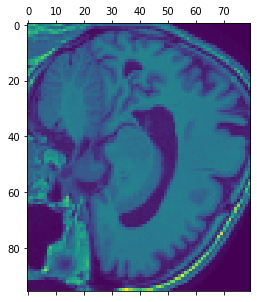

In [49]:
plt.matshow(template_data[0][30])
plt.show()

In [50]:
caps_info = pd.read_csv('/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv', sep='\t', 
                        error_bad_lines=False)[['participant_id', 'session_id', 'age', 'diagnosis', 'MMSE']].set_index(['participant_id','session_id'])

/home/benoit.sautydechalon/anaconda3/envs/pami/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (117,118,119,310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [51]:
caps_info

age diagnosis  MMSE
participant_id   session_id                      
sub-ADNI002S0295 ses-M00     84.8        CN  28.0
                 ses-M06     85.3        CN  28.0
                 ses-M12     85.8        CN  30.0
                 ses-M24     87.0        CN  29.0
                 ses-M36     87.8        CN  28.0
...                           ...       ...   ...
sub-ADNI941S6581 ses-M00     74.4        CN  30.0
                 ses-M12     75.4       NaN   NaN
                 ses-M24     76.4       NaN  30.0
sub-ADNI941S6803 ses-M00     75.0       MCI  28.0
sub-ADNI941S6854 ses-M00     86.2        AD  30.0

[16319 rows x 3 columns]

In [ ]:
path_imaging_data = "/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/"

sub_lst = sorted(os.listdir(path_imaging_data))
data_dict = {'data':template_data, 'target':torch.ones(1), 'label':torch.empty(1)}

number_of_patients = 500
i = 0 

for sub in tqdm(sub_lst):
    
    if i == number_of_patients:
        break
        
    sub_id = sub[12:]
    sub_path = path_imaging_data+sub
    ses_lst = sorted(os.listdir(sub_path))
    
    if caps_info.loc[sub]['MMSE'].between(10, 25).any():
        i += 1
        for ses in ses_lst:

            ses_path = os.path.join(sub_path, ses)
            filename = 'deeplearning_prepare_data/image_based/t1_linear/' + sub + '_' + ses + '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
            ses_data_path = os.path.join(ses_path, filename)

            if (caps_info.loc[(sub,ses)]['diagnosis'] in ['MCI', 'AD']):
                # Load the data
                ses_torch = torch.load(ses_data_path)
                # Subsample
                ses_torch = ses_torch[:,4:164:2,8:200:2,8:168:2]
                # Normalize
                ses_torch = ses_torch/ses_torch.max()

                data_dict['data'] = torch.cat((data_dict['data'], ses_torch))
                data_dict['target'] = torch.cat((data_dict['target'], torch.tensor([caps_info.loc[(sub,ses)]['age']])))
                data_dict['label'] = torch.cat((data_dict['label'], torch.tensor([int(sub_id)])))
                

# Threshold to have a lot of 0 values in the input
mask_threshold = data_dict['data']<(torch.tensor(1e-2))
data_dict['data'][mask_threshold] = 0
        
# Then add the (useless targets) and delete the template data
data_dict['data'], data_dict['target'], data_dict['label'] = data_dict['data'][1:], data_dict['target'][1:], data_dict['label'][1:]

data_dict

 41%|████      | 913/2254 [46:13<2:15:48,  6.08s/it]

In [ ]:
print(f"There are {data_dict['data'].shape[0]} patients with a total of {data_dict['data'].shape[1]*data_dict['data'].shape[2]*data_dict['data'].shape[3]} dimentions")

In [ ]:
torch.save(data_dict, 'ADNI_full')

## Load the saved data and take only a subset to allow faster training

In [61]:
data = torch.load('ADNI_full')

In [69]:
data['data'].shape

torch.Size([2065, 80, 96, 80])

In [75]:
already_seen = []
index = []
i = -1

for sub in data['label']:
    if sub in already_seen:
        index.append(i)
    else:
        i += 1
        already_seen.append(sub)
        index.append(i)
        
torch.tensor(index) 

tensor([  0,   0,   0,  ..., 478, 478, 478])

## Mini-dataset for debugging

In [77]:
mini_data = {}
mini_data['data'] = data['data'][:10]
mini_data['target'] = [(index[i], float(data['target'][i])) for i in range(10)]
mini_data['ADNI_id'] = data['label'][:10]

In [79]:
torch.save(mini_data,'mini_dataset')

## Small-dataset for testing

In [80]:
mini_data = {}
mini_data['data'] = data['data'][:100]
mini_data['ADNI_id'] = data['label'][:100]
mini_data['target'] = [(index[i], float(data['target'][i])) for i in range(100)]
mini_data['ADNI_id'] = data['label'][:100]

In [81]:
torch.save(mini_data,'small_dataset')

## Large dataset for training

In [82]:
mini_data = {}
mini_data['data'] = data['data']
mini_data['ADNI_id'] = data['label']
mini_data['target'] = [(index[i], float(data['target'][i])) for i in range(len(data['data']))]

In [83]:
torch.save(mini_data,'large_dataset')

## Data-analysis on the encoded images

In [7]:
encoded = torch.load('../deformetrica/deformetrica/LAE_experiments/encoded_datasetCAE_300_epochs_5e-5_lr')

In [32]:
data = encoded['data']

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [28]:
data = scale(data)

In [27]:
data.mean()

tensor(0.5189)

In [33]:
covar_matrix = PCA(n_components = 20)

In [34]:
covar_matrix.fit(data)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features


array([68.7, 72.7, 74.1, 75. , 75.6, 76.1, 76.6, 77. , 77.3, 77.6, 77.9,
       78.2, 78.5, 78.8, 79.1, 79.3, 79.5, 79.7, 79.9, 80.1])